In [1]:
import pandas as pd
from pathlib import Path

In [2]:
DIR = Path("salmon") / "io" / "2021-11-08"

dfs = {f.name.replace("ARR-scores=", "").replace(".csv", ""): pd.read_csv(f) for f in DIR.glob("*.csv")}
print(dfs.keys())
dfs["random"].head()

dict_keys(['original', 'approx', 'random'])


,head,left,right,winner,alg_ident,score,puid,response_time,network_latency,time_received,...,winner_html,loser_html,left_filename,right_filename,head_filename,winner_filename,loser_filename,time_received_since_start,datetime_received,start_time
0,0,11,82,11,ARR,-9999.0,0,1.910224,-1,1.636408e+09,...,90,551,90,551,22,90,551,9.020471,2021-11-08T21:41:01.312000,1.636408e+09
1,19,57,9,9,ARR,-9999.0,1,1.913034,-1,1.636408e+09,...,76,378,378,76,126,76,378,9.497471,2021-11-08T21:41:01.789000,1.636408e+09
2,43,39,41,41,ARR,-9999.0,0,1.778813,-1,1.636408e+09,...,251,248,248,251,256,251,248,11.013471,2021-11-08T21:41:03.305000,1.636408e+09
3,5,85,78,78,ARR,-9999.0,1,1.609241,-1,1.636408e+09,...,524,563,563,524,54,524,563,11.265471,2021-11-08T21:41:03.557000,1.636408e+09
4,18,78,67,78,ARR,-9999.0,0,1.669097,-1,1.636408e+09,...,524,438,524,438,125,524,438,12.833471,2021-11-08T21:41:05.125000,1.636408e+09


In [3]:
def _get_unique_heads(df):
    d = df[df.score > -100]
    return d.rolling(window=90)["head"].apply(lambda x: x.nunique())
    
unique_heads = {k: _get_unique_heads(df) for k, df in dfs.items()}

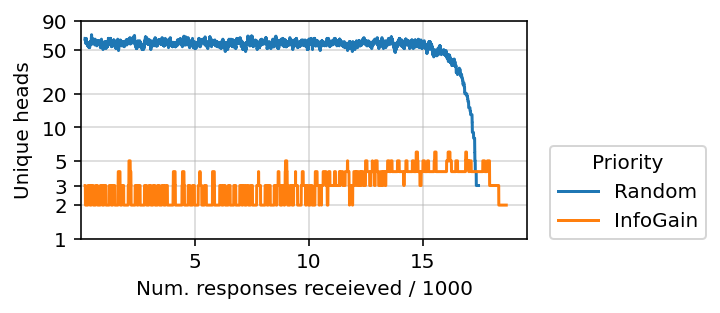

In [5]:
_show = []
for k, uniques in unique_heads.items():
    u = pd.DataFrame(uniques)
    u["priority"] = k
    u["index"] = uniques.index
    _show.append(u)
show = pd.concat(_show)
import seaborn as sns
import matplotlib.pyplot as plt

names = {"original": "InfoGain", "random": "Random", "approx": "ApproxRank"}
show["Priority"] = show["priority"].apply(names.get)

w = 2.0
fig, ax = plt.subplots(figsize=(2.0 * w, w))
ax = sns.lineplot(
    x="index",
    y="head",
    hue="Priority",
    hue_order=["Random", "InfoGain"],
    data=show[show.Priority != "ApproxRank"],
    ci=None,
    ax=ax,
)
ax.set_ylim(1, 90)
ax.set_xlim(1, None)
ax.legend(loc=(1.05, 0), title="Priority")
logscaled = sum([[1 * i, 2 * i, 5 * i] for i in [1e0, 1e1, 1e2, 1e3]], [])
ax.set_yscale("log", base=2)
ax.yaxis.set_major_locator(plt.FixedLocator(logscaled + [3, 90]))
ax.yaxis.set_major_formatter(lambda x, _: str(int(x)))
ax.xaxis.set_major_formatter(lambda x, _: str(int(x / 1000)))
ax.set_ylabel("Unique heads")
ax.set_xlabel("Num. responses receieved / 1000")
ax.grid(alpha=0.5)
fig.savefig("figures/unique_heads.png", dpi=300, bbox_inches="tight", transparent=True)
# ax.legend(loc="upper right")